<a href="https://colab.research.google.com/github/Lakshmi-krishna-vr/Computational_Optimization_/blob/main/LPP_module_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sample problem 1: The “Exam Style” Tabular Problem
Scenario: Complete the table to find the project parameters.
Given Data:

- A (4), B (3) start at 0.
- C (2) depends on A.
- D (5) depends on A.
- E (6) depends on B.
- F (3) depends on C, D, E.

Python solution to fill the table

--- CPM Calculation Results ---
      Duration  ES  EF  LS  LF  Slack  Critical
Task                                           
A            4   0   4   0   4      0      True
B            3   0   3   0   3      0      True
C            2   4   6   7   9      3     False
D            5   4   9   4   9      0      True
E            6   3   9   3   9      0      True
F            3   9  12   9  12      0      True
--------------------------------------------------


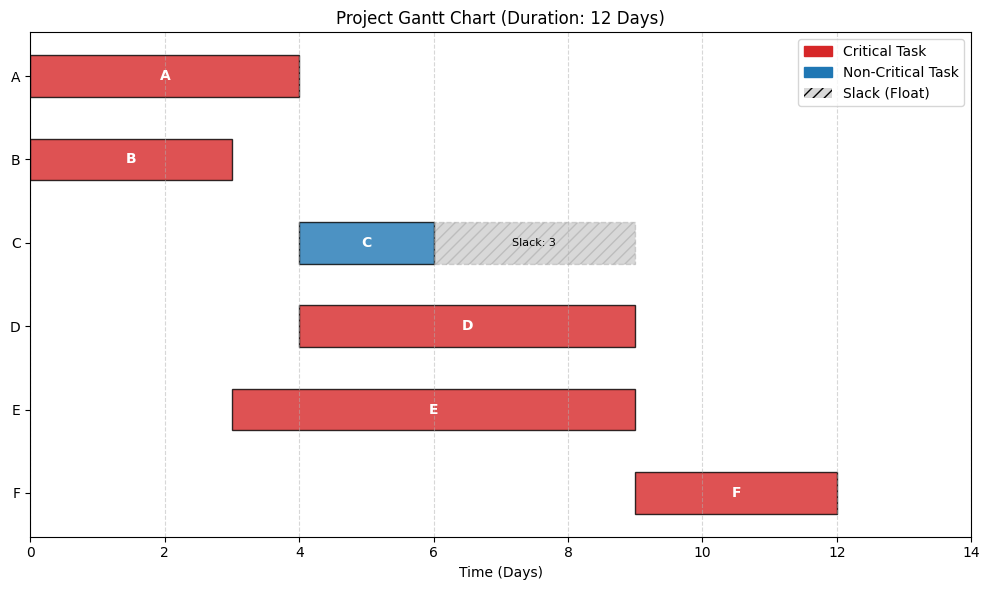

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- PART 1: CPM CALCULATION ---

# 1. Define Project Data
tasks = {
    'A': {'duration': 4, 'preds': []},
    'B': {'duration': 3, 'preds': []},
    'C': {'duration': 2, 'preds': ['A']},
    'D': {'duration': 5, 'preds': ['A']},
    'E': {'duration': 6, 'preds': ['B']},
    'F': {'duration': 3, 'preds': ['C', 'D', 'E']}
}

# 2. Build Graph
G = nx.DiGraph()
for task, data in tasks.items():
    G.add_node(task, duration=data['duration'])
    for pred in data['preds']:
        G.add_edge(pred, task)

# 3. Forward Pass (Earliest Start/Finish)
early_start = {}
early_finish = {}
for task in nx.topological_sort(G):
    preds = list(G.predecessors(task))
    es = max((early_finish[p] for p in preds), default=0)
    duration = G.nodes[task]['duration']
    early_start[task] = es
    early_finish[task] = es + duration

project_duration = max(early_finish.values())

# 4. Backward Pass (Latest Start/Finish)
late_start = {}
late_finish = {}
for task in reversed(list(nx.topological_sort(G))):
    succs = list(G.successors(task))
    lf = min((late_start[s] for s in succs), default=project_duration)
    duration = G.nodes[task]['duration']
    late_start[task] = lf - duration
    late_finish[task] = lf

# 5. Calculate Slack & Criticality
results = []
for t in tasks:
    es, ef = early_start[t], early_finish[t]
    ls, lf = late_start[t], late_finish[t]
    slack = ls - es
    is_critical = (slack == 0)
    results.append({
        'Task': t, 'Duration': tasks[t]['duration'],
        'ES': es, 'EF': ef, 'LS': ls, 'LF': lf,
        'Slack': slack, 'Critical': is_critical
    })

# Create DataFrame for CPM Table
df_cpm = pd.DataFrame(results).set_index('Task')
print("--- CPM Calculation Results ---")
print(df_cpm)
print("-" * 50)

# --- PART 2: GANTT CHART VISUALIZATION ---

fig, ax = plt.subplots(figsize=(10, 6))

# Define positions
y_positions = range(len(results), 0, -1)
yticks = [r['Task'] for r in results]

for i, row in enumerate(results):
    y = y_positions[i]
    task = row['Task']
    start = row['ES']
    dur = row['Duration']
    slack = row['Slack']

    # 1. Main Task Bar
    color = 'tab:red' if row['Critical'] else 'tab:blue'
    ax.barh(y, dur, left=start, height=0.5, color=color, edgecolor='black', alpha=0.8)

    # 2. Slack Bar (Ghost Bar)
    if slack > 0:
        ax.barh(y, slack, left=start + dur, height=0.5,
                color='gray', alpha=0.3, hatch='///', edgecolor='gray', linestyle='--')
        ax.text(start + dur + slack/2, y, f"Slack: {slack}",
                ha='center', va='center', fontsize=8, color='black')

    # Label inside bar
    ax.text(start + dur/2, y, task, ha='center', va='center',
            color='white', fontweight='bold')

# Chart Formatting
ax.set_yticks(y_positions)
ax.set_yticklabels(yticks)
ax.set_xlabel("Time (Days)")
ax.set_title(f"Project Gantt Chart (Duration: {project_duration} Days)")
ax.set_xlim(0, project_duration + 2)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Legend
legend_elements = [
    mpatches.Patch(color='tab:red', label='Critical Task'),
    mpatches.Patch(color='tab:blue', label='Non-Critical Task'),
    mpatches.Patch(facecolor='gray', alpha=0.3, hatch='///', label='Slack (Float)')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

## 4.4.8 Sample Problem
Problem Statement: A campus renovation project has the following activities with crashing costs (cost to reduce duration by 1 week):

| Activity | Normal Time | Crash Time | Normal Cost | Crash Cost |Predecessors |
| :--- | :--| :---  | :---  | :---  | :--- |
| A | 3 | 2 | $1000   | $1500 | -    |
| B | 4 | 3 | $2000   | $2600 | A    |
| C | 5 | 4 | $1500   | $2000 | A    |
| D | 6 | 4 | $3000   | $4200 | B, C |

Find the minimum cost schedule to complete in 10 weeks.

Solution Approach: Use CPM with time-cost trade-off analysis (crashing). Calculate cost slope = (Crash Cost - Normal Cost)/(Normal Time - Crash Time) and crash activities on critical path starting with lowest cost slope.

Python solution

In [ ]:
import networkx as nx
import pandas as pd
from itertools import combinations

# ---------------------------------------------------------
# 1. Setup Project Data
# ---------------------------------------------------------
# Format: {Activity: {NormalT, CrashT, NormalC, CrashC, Predecessors}}
data = {
    'A': {'nT': 3, 'cT': 2, 'nC': 1000, 'cC': 1500, 'pred': []},
    'B': {'nT': 4, 'cT': 3, 'nC': 2000, 'cC': 2600, 'pred': ['A']},
    'C': {'nT': 5, 'cT': 4, 'nC': 1500, 'cC': 2000, 'pred': ['A']},
    'D': {'nT': 6, 'cT': 4, 'nC': 3000, 'cC': 4200, 'pred': ['B', 'C']}
}

TARGET_DURATION = 10

# ---------------------------------------------------------
# 2. Helper Functions
# ---------------------------------------------------------

def calculate_slope(task):
    """Calculates Cost Slope = (Crash Cost - Normal Cost) / (Normal Time - Crash Time)"""
    props = data[task]
    if props['nT'] == props['cT']: return float('inf') # Cannot crash
    return (props['cC'] - props['nC']) / (props['nT'] - props['cT'])

def get_project_duration(current_times):
    """Runs CPM Forward Pass to find Project Duration"""
    G = nx.DiGraph()
    for task, props in data.items():
        G.add_node(task, duration=current_times[task])
        for p in props['pred']:
            G.add_edge(p, task)

    # Calculate Earliest Finish (EF)
    early_finish = {}
    for task in nx.topological_sort(G):
        preds = list(G.predecessors(task))
        es = max((early_finish[p] for p in preds), default=0)
        early_finish[task] = es + current_times[task]

    return max(early_finish.values())

# ---------------------------------------------------------
# 3. Initialization
# ---------------------------------------------------------
# Current state of durations (Starts at Normal Time)
current_times = {t: data[t]['nT'] for t in data}
current_cost = sum(data[t]['nC'] for t in data)
history = []

# Calculate Slopes
slopes = {t: calculate_slope(t) for t in data}

# ---------------------------------------------------------
# 4. Iterative Crashing Loop
# ---------------------------------------------------------
print("--- Crashing Analysis Log ---")

while True:
    duration = get_project_duration(current_times)
    history.append({'Duration': duration, 'Total Cost': current_cost, 'Action': 'Status Check'})

    if duration <= TARGET_DURATION:
        print(f"Target of {TARGET_DURATION} weeks reached!")
        break

    # Find the Best Move (Cheapest way to reduce duration by 1 unit)
    best_move = None
    min_move_cost = float('inf')

    # Strategy A: Try crashing single tasks
    candidates = [t for t in data if current_times[t] > data[t]['cT']]

    for task in candidates:
        # Simulate Crash
        current_times[task] -= 1
        new_dur = get_project_duration(current_times)
        current_times[task] += 1 # Revert

        # If duration decreased, this is a valid move
        if new_dur < duration:
            cost = slopes[task]
            if cost < min_move_cost:
                min_move_cost = cost
                best_move = [task]

    # Strategy B: If single tasks fail (due to parallel critical paths), try pairs
    if best_move is None:
        # We need to crash two parallel tasks simultaneously (e.g., B and C)
        for t1, t2 in combinations(candidates, 2):
            current_times[t1] -= 1
            current_times[t2] -= 1
            new_dur = get_project_duration(current_times)
            current_times[t1] += 1
            current_times[t2] += 1

            if new_dur < duration:
                cost = slopes[t1] + slopes[t2]
                if cost < min_move_cost:
                    min_move_cost = cost
                    best_move = [t1, t2]

    # Apply the Best Move
    if best_move:
        actions_str = ""
        for task in best_move:
            current_times[task] -= 1
            current_cost += slopes[task]
            actions_str += f"Crash {task} (-1 wk, +${slopes[task]}); "

        print(f"Current Duration: {duration} wks. Action: {actions_str}")
    else:
        print("Cannot crash further (Max limit reached).")
        break

# ---------------------------------------------------------
# 5. Final Output
# ---------------------------------------------------------
df_res = pd.DataFrame(history)
print("\n--- Final Project Schedule ---")
print(f"Final Duration: {get_project_duration(current_times)} weeks")
print(f"Final Total Cost: ${current_cost}")
print(f"Durations: {current_times}")
print("-" * 40)
print(df_res)

--- Crashing Analysis Log ---
Current Duration: 14 wks. Action: Crash A (-1 wk, +$500.0); 
Current Duration: 13 wks. Action: Crash C (-1 wk, +$500.0); 
Current Duration: 12 wks. Action: Crash D (-1 wk, +$600.0); 
Current Duration: 11 wks. Action: Crash D (-1 wk, +$600.0); 
Target of 10 weeks reached!

--- Final Project Schedule ---
Final Duration: 10 weeks
Final Total Cost: $9700.0
Durations: {'A': 2, 'B': 4, 'C': 4, 'D': 4}
----------------------------------------
   Duration  Total Cost        Action
0        14      7500.0  Status Check
1        13      8000.0  Status Check
2        12      8500.0  Status Check
3        11      9100.0  Status Check
4        10      9700.0  Status Check


##  Problem 3: The “Hello World” of CPM
Scenario: A simple linear workflow with one parallel branch.

| Activity | Predecessors | Duration (Days) |
| :--- | :--- | :--- |
| A | - | 3 |
| B | A | 4 |
| C | A | 2 |
| D | B, C | 5 |

Mathematical Solution:

Step 1: Forward Pass (Find ES, EF)

A: Start at 0. Duration 3. \to EF = 7
.

B: Predecessor A (ends at 3). Start at 3. Duration 4.
.

C: Predecessor A (ends at 3). Start at 3. Duration 2.
.

D: Predecessors B (ends 7) and C (ends 5).

Rule: We must wait for the slowest one. \max(7, 5) = 7
.
Start at 7. Duration 5 \to EF = 12 .
.